Traviling saleman problem

In [426]:
import matplotlib.pyplot as plt
import math
from itertools import permutations
import json
import re

In [427]:
from time import perf_counter

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start = perf_counter()
        result = func(*args, **kwargs)
        end = perf_counter()
        print(f"time elapsed in {func.__name__}: {end - start} seconds")
        return result
    return wrapper

In [428]:
def draw_path(points, color):

    # Unpack the list of points into X and Y coordinates
    x_values, y_values = zip(*points)

    # Plot the points
    plt.plot(x_values, y_values, 'bo')  # 'bo' creates blue circles at the points

    # Draw lines between the points
    plt.plot(x_values, y_values, linestyle='-', color=color)  # Line with default color

    # Optionally, you can add labels to the points
    for (x, y) in points:
        plt.text(x, y, f'({x},{y})')

    # Display the plot
    plt.show()

def draw_ranges(ranges, color):

    # Unpack the list of points into X and Y coordinates
    for r in ranges:
        x_values, y_values = zip(*r)

        # Plot the points
        plt.plot(x_values, y_values, 'bo')  # 'bo' creates blue circles at the points

        # Draw lines between the points
        plt.plot(x_values, y_values, linestyle='-', color=color)  # Line with default color

        # Optionally, you can add labels to the points
        for (x, y) in r:
            plt.text(x, y, f'({x},{y})')

    # Display the plot
    plt.show()

In [429]:
def calculate_distance(point1, point2):
    """Calculate the Euclidean distance between two points."""
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def total_distance(points):
    """Calculate the total distance of the path that visits all points."""
    return sum(calculate_distance(point, points[index + 1]) for index, point in enumerate(points[:-1]))

@timing_decorator
def brute_force_tsp(coordinates):
    """Find the shortest route to visit all cities and return to the original city."""
    shortest_route = []
    min_distance = float('inf')

    for permutation in permutations(coordinates):
        # Add the start point to the end to make a complete loop
        current_route = permutation + (permutation[0],)
        current_distance = total_distance(current_route)
        
        if current_distance < min_distance:
            min_distance = current_distance
            shortest_route = current_route
            
    return [r for r in shortest_route], min_distance



@timing_decorator
def nearest_neighbor_algorithm_prof(coordinates, start=0):
    return nearest_neighbor_algorithm(coordinates, start)

def nearest_neighbor_algorithm(coordinates, start):
    num_cities = len(coordinates)
    visited = [False] * num_cities
    tour = [coordinates[start]]  # Start the tour from the first city
    visited[start] = True
    total_distance = 0

    current_city = start

    while len(tour) < num_cities:
        nearest_city = None
        nearest_distance = float('inf')

        for next_city in range(num_cities):
            if not visited[next_city]:
                distance = calculate_distance(coordinates[current_city], coordinates[next_city])
                if distance < nearest_distance:
                    nearest_city = next_city
                    nearest_distance = distance

        visited[nearest_city] = True
        tour.append(coordinates[nearest_city])
        total_distance += nearest_distance
        current_city = nearest_city

    # Add distance back to the starting city to complete the tour
    total_distance += calculate_distance(coordinates[current_city], coordinates[start])
    tour.append(coordinates[start])  # Optional: to show the tour returns to the start

    return tour, total_distance

@timing_decorator
def nearest_neighbor_better_algorithm(coordinates):
    min_route = None
    min_distance = None
    for point in range(len(coordinates)):
        route, distance = nearest_neighbor_algorithm(coordinates, point)
        if min_distance is None or min_distance > distance:
            min_distance = distance
            min_route = route

    return min_route, min_distance


def create_edges(coordinates):
    """Generate all edges with distances between points."""
    edges = []
    num_points = len(coordinates)
    for i in range(num_points):
        for j in range(i + 1, num_points):
            distance = calculate_distance(coordinates[i], coordinates[j])
            edges.append((i, j, distance))
    return edges

def find_cheapest_link(edges, connected, remaining):
    """Find the cheapest edge connecting an unconnected point."""
    cheapest_edge = None
    for edge in edges:
        if (edge[0] in connected and edge[1] in remaining) or (edge[1] in connected and edge[0] in remaining):
            if cheapest_edge is None or edge[2] < cheapest_edge[2]:
                cheapest_edge = edge
    return cheapest_edge

def forms_cycle(edges, num_points):
    """Check if the selected edges form a cycle."""
    parent = list(range(num_points))

    def find(x):
        if parent[x] != x:
            parent[x] = find(parent[x])
        return parent[x]

    def union(x, y):
        rootX = find(x)
        rootY = find(y)
        if rootX != rootY:
            parent[rootX] = rootY
            return False
        return True

    for edge in edges:
        if union(edge[0], edge[1]):
            return True  # Cycle formed
    return False  # No cycle

@timing_decorator
def cheapest_link_algorithm(coordinates):
    edges = create_edges(coordinates)
    edges.sort(key=lambda x: x[2])  # Sort edges based on distance

    num_points = len(coordinates)
    tour_edges = []  # Edges selected for the tour
    degree = [0] * num_points  # Track the degree of each vertex

    # Select edges ensuring no vertex degree exceeds 2 and avoiding creating a cycle prematurely
    for edge in edges:
        if degree[edge[0]] < 2 and degree[edge[1]] < 2:
            # Check if adding this edge creates a cycle when not all vertices are included yet
            if forms_cycle(tour_edges + [edge], num_points):
                continue
            tour_edges.append(edge)
            degree[edge[0]] += 1
            degree[edge[1]] += 1
            if len(tour_edges) == num_points - 1:  # All vertices connected, but not a cycle yet
                break

    # Find and add the last edge to complete the cycle
    for edge in edges:
        if degree[edge[0]] < 2 and degree[edge[1]] < 2:
            tour_edges.append(edge)
            break

    return tour_edges, sum(e[2] for e in tour_edges)


@timing_decorator
def cheapest_insertion_algorithm(coordinates):
    num_cities = len(coordinates)
    # Start with a subtour consisting of the first three cities
    tour = [0, 1, 2, 0]
    unvisited = set(range(3, num_cities))

    while unvisited:
        cheapest_increase = float('inf')
        cheapest_city = None
        cheapest_position = None

        # Find the cheapest city to insert
        for city in unvisited:
            for i in range(len(tour) - 1):
                increase = (calculate_distance(coordinates[tour[i]], coordinates[city]) +
                            calculate_distance(coordinates[city], coordinates[tour[i + 1]]) -
                            calculate_distance(coordinates[tour[i]], coordinates[tour[i + 1]]))
                if increase < cheapest_increase:
                    cheapest_increase = increase
                    cheapest_city = city
                    cheapest_position = i + 1

        # Insert the cheapest city into the subtour
        tour.insert(cheapest_position, cheapest_city)
        unvisited.remove(cheapest_city)

    return [coordinates[i] for i in tour], sum([calculate_distance(coordinates[tour[i]], coordinates[tour[i + 1]]) for i in range(0, len(tour) - 1)])




Рисовать граф можно [тут](https://csacademy.com/app/graph_editor/)

In [430]:
def convert2points(nodes):
    fixed_data = re.sub(r"(\w+)(\s*:\s*)", r'"\1"\2', nodes)
    print(fixed_data)
    nodes = json.loads(fixed_data.replace("'", '"'))
    return[(node['center']['x'], node['center']['y']) for node in nodes]

In [431]:
nodes = '[{label:"1",center:{x:120.9,y:86.1}},{label:"2",center:{x:399,y:81.3}},{label:"3",center:{x:91.9,y:39.6}},{label:"4",center:{x:394.2,y:363.3}},{label:"5",center:{x:341.6,y:331}},{label:"6",center:{x:227,y:222.6}},{label:7,center:{x:374.1,y:37.9}},{label:8,center:{x:195.1,y:198.4}},{label:9,center:{x:64,y:81}},{label:10,center:{x:341.6,y:390.3}}]'
coordinates = convert2points('[{label:2,center:{x:100.2,y:201.3}},{label:3,center:{x:387.4,y:234.4}},{label:4,center:{x:72.3,y:76}},{label:"1",center:{x:223,y:60.4}},{label:"5",center:{x:43.8,y:162.1}},{label:6,center:{x:72.9,y:346.6}},{label:7,center:{x:254.5,y:345}},{label:8,center:{x:156.6,y:249.8}},{label:9,center:{x:143,y:108.5}}]')

[{"label":2,"center":{"x":100.2,"y":201.3}},{"label":3,"center":{"x":387.4,"y":234.4}},{"label":4,"center":{"x":72.3,"y":76}},{"label":"1","center":{"x":223,"y":60.4}},{"label":"5","center":{"x":43.8,"y":162.1}},{"label":6,"center":{"x":72.9,"y":346.6}},{"label":7,"center":{"x":254.5,"y":345}},{"label":8,"center":{"x":156.6,"y":249.8}},{"label":9,"center":{"x":143,"y":108.5}}]


time elapsed in brute_force_tsp: 0.8017914579249918 seconds
Shortest route: [(100.2, 201.3), (43.8, 162.1), (72.3, 76), (143, 108.5), (223, 60.4), (387.4, 234.4), (254.5, 345), (72.9, 346.6), (156.6, 249.8), (100.2, 201.3)]
Minimum distance: 1126.7813521365063


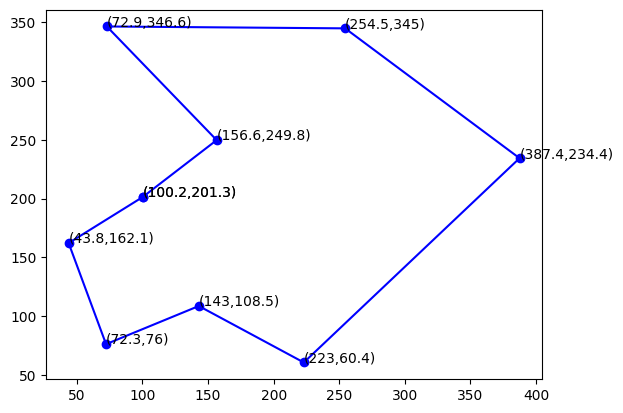

time elapsed in nearest_neighbor_algorithm_prof: 2.208305522799492e-05 seconds
Shortest route: [(100.2, 201.3), (43.8, 162.1), (72.3, 76), (143, 108.5), (223, 60.4), (156.6, 249.8), (72.9, 346.6), (254.5, 345), (387.4, 234.4), (100.2, 201.3)]
Minimum distance: 1302.8177748285161


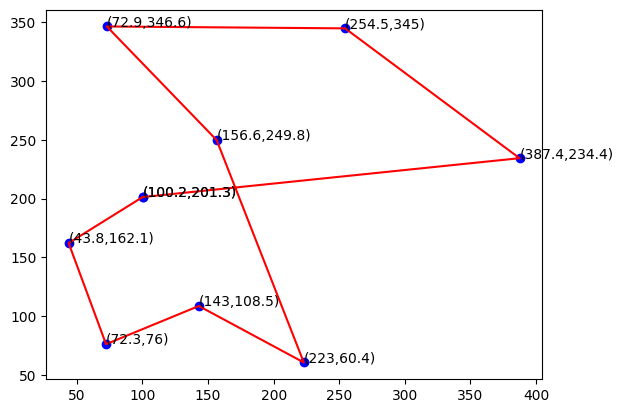

time elapsed in nearest_neighbor_better_algorithm: 0.00036920804996043444 seconds
Shortest route: [(43.8, 162.1), (100.2, 201.3), (156.6, 249.8), (72.9, 346.6), (254.5, 345), (387.4, 234.4), (223, 60.4), (143, 108.5), (72.3, 76), (43.8, 162.1)]
Minimum distance: 1126.7813521365063


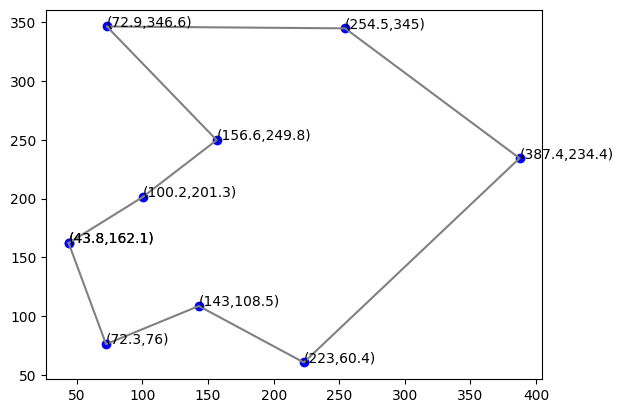

time elapsed in cheapest_link_algorithm: 4.191696643829346e-05 seconds
Shortest route: [(0, 4, 68.68478725307375), (0, 7, 74.3855496719625), (2, 8, 77.81220983881643), (2, 4, 90.69432176272117), (3, 8, 93.34671927818353), (5, 7, 127.96847267979719), (1, 6, 172.90104106106472), (5, 6, 181.60704832136884), (1, 3, 239.3812022695182)]
Minimum distance: 1126.7813521365063


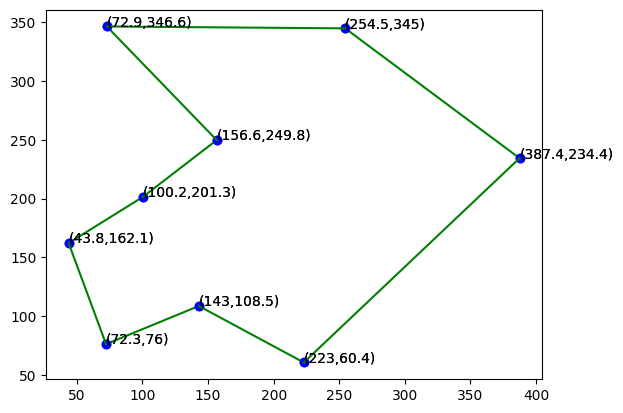

time elapsed in cheapest_insertion_algorithm: 8.14161030575633e-05 seconds
Shortest route: [(100.2, 201.3), (156.6, 249.8), (72.9, 346.6), (254.5, 345), (387.4, 234.4), (223, 60.4), (143, 108.5), (72.3, 76), (43.8, 162.1), (100.2, 201.3)]
Minimum distance: 1126.7813521365063


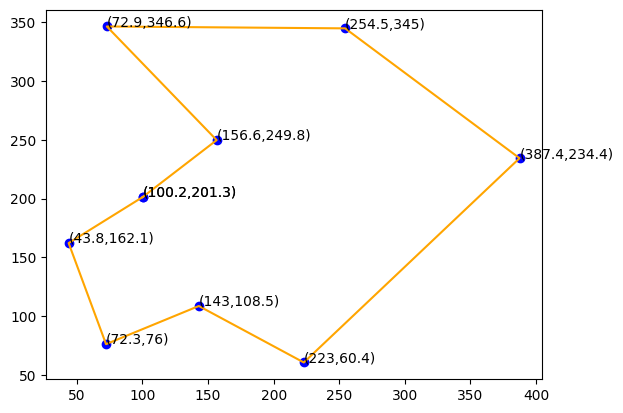

In [432]:
shortest_route, min_distance = brute_force_tsp(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'blue')

shortest_route, min_distance =nearest_neighbor_algorithm_prof(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'red')

shortest_route, min_distance =nearest_neighbor_better_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'gray')


shortest_route, min_distance = cheapest_link_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
rr = [[coordinates[r[0]], coordinates[r[1]]] for r in shortest_route]
draw_ranges(rr, 'green')

shortest_route, min_distance = cheapest_insertion_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'orange')


[{"label":2,"center":{"x":95.3,"y":307.7}},{"label":3,"center":{"x":176,"y":271}},{"label":4,"center":{"x":131,"y":191.4}},{"label":"1","center":{"x":373.8,"y":56.2}},{"label":"5","center":{"x":51.6,"y":237.4}}]
[(0, 1, 88.65314433227961), (0, 2, 121.65599039915789), (0, 3, 375.2525816033782), (0, 4, 82.77547946100945), (1, 2, 91.43937882553665), (1, 3, 291.99979452047563), (1, 4, 128.85775102802313), (2, 3, 277.9044440090874), (2, 4, 91.76251958179876), (3, 4, 369.65697612786914)]
time elapsed in brute_force_tsp: 0.00018450000789016485 seconds
Shortest route: [(95.3, 307.7), (176, 271), (373.8, 56.2), (131, 191.4), (51.6, 237.4), (95.3, 307.7)]
Minimum distance: 833.0953819046508


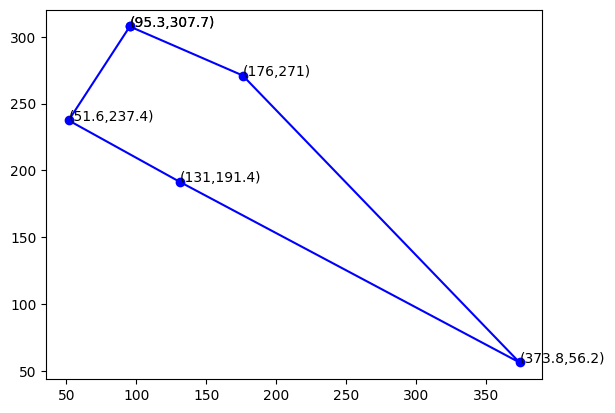

time elapsed in nearest_neighbor_algorithm_prof: 1.1415919288992882e-05 seconds
Shortest route: [(95.3, 307.7), (51.6, 237.4), (131, 191.4), (176, 271), (373.8, 56.2), (95.3, 307.7)]
Minimum distance: 933.2297539921987


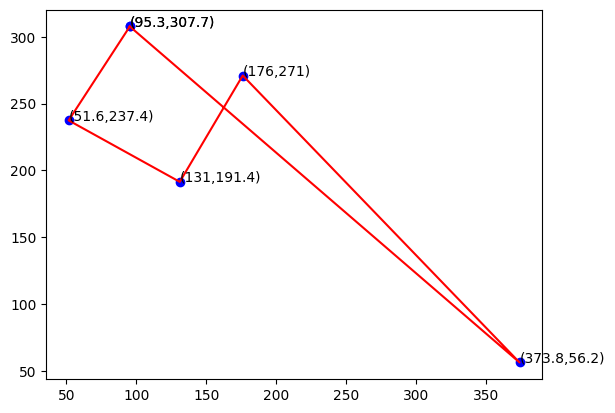

time elapsed in nearest_neighbor_better_algorithm: 2.8665992431342602e-05 seconds
Shortest route: [(176, 271), (95.3, 307.7), (51.6, 237.4), (131, 191.4), (373.8, 56.2), (176, 271)]
Minimum distance: 833.0953819046508


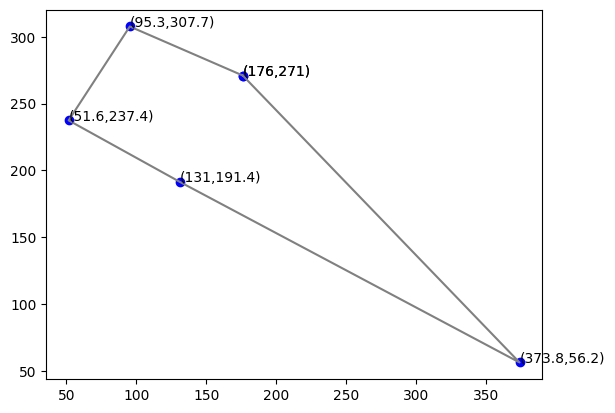

time elapsed in cheapest_link_algorithm: 2.1625077351927757e-05 seconds
Shortest route: [(0, 4, 82.77547946100945), (0, 1, 88.65314433227961), (1, 2, 91.43937882553665), (2, 3, 277.9044440090874), (3, 4, 369.65697612786914)]
Minimum distance: 910.4294227557823


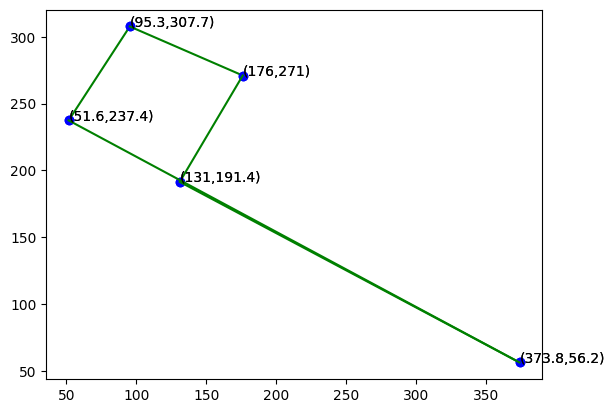

time elapsed in cheapest_insertion_algorithm: 2.833292819559574e-05 seconds
Shortest route: [(95.3, 307.7), (176, 271), (373.8, 56.2), (131, 191.4), (51.6, 237.4), (95.3, 307.7)]
Minimum distance: 833.0953819046508


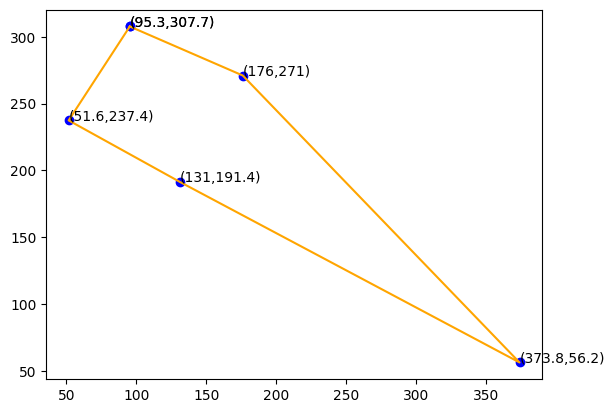

In [433]:
coordinates = convert2points('[{label:2,center:{x:95.3,y:307.7}},{label:3,center:{x:176,y:271}},{label:4,center:{x:131,y:191.4}},{label:"1",center:{x:373.8,y:56.2}},{label:"5",center:{x:51.6,y:237.4}}]')
print(create_edges(coordinates))
shortest_route, min_distance =brute_force_tsp(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'blue')

shortest_route, min_distance =nearest_neighbor_algorithm_prof(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'red')

shortest_route, min_distance =nearest_neighbor_better_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'gray')


shortest_route, min_distance = cheapest_link_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
rr = [[coordinates[r[0]], coordinates[r[1]]] for r in shortest_route]
draw_ranges(rr, 'green')

shortest_route, min_distance = cheapest_insertion_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'orange')

[{"label":2,"center":{"x":100.2,"y":201.3}},{"label":3,"center":{"x":282.5,"y":343.1}},{"label":4,"center":{"x":81,"y":109.1}},{"label":"1","center":{"x":371.5,"y":54.6}},{"label":"5","center":{"x":43.8,"y":162.1}},{"label":6,"center":{"x":359.3,"y":120.4}},{"label":7,"center":{"x":246.8,"y":396.4}},{"label":8,"center":{"x":189.6,"y":362.4}},{"label":9,"center":{"x":293.5,"y":57.1}}]
time elapsed in brute_force_tsp: 0.7650775000220165 seconds
Shortest route: [(100.2, 201.3), (43.8, 162.1), (81, 109.1), (293.5, 57.1), (371.5, 54.6), (359.3, 120.4), (282.5, 343.1), (246.8, 396.4), (189.6, 362.4), (100.2, 201.3)]
Minimum distance: 1047.6754145493037


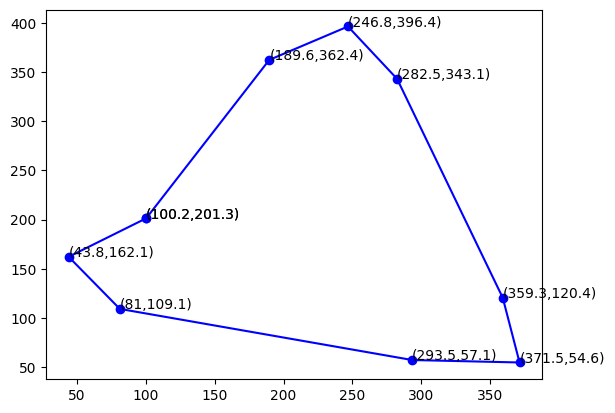

time elapsed in nearest_neighbor_algorithm_prof: 1.6208039596676826e-05 seconds
Shortest route: [(100.2, 201.3), (43.8, 162.1), (81, 109.1), (293.5, 57.1), (371.5, 54.6), (359.3, 120.4), (282.5, 343.1), (246.8, 396.4), (189.6, 362.4), (100.2, 201.3)]
Minimum distance: 1047.675414549304


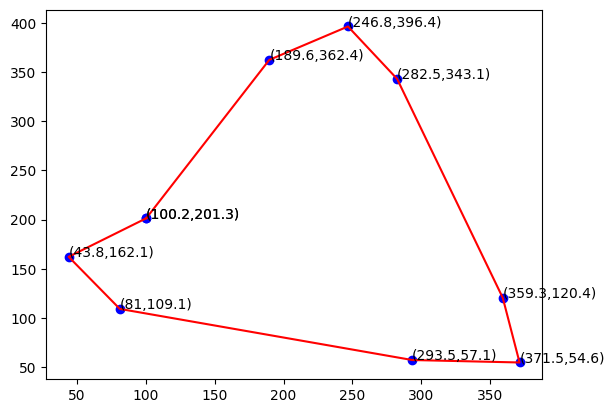

time elapsed in nearest_neighbor_better_algorithm: 9.279197547584772e-05 seconds
Shortest route: [(359.3, 120.4), (371.5, 54.6), (293.5, 57.1), (81, 109.1), (43.8, 162.1), (100.2, 201.3), (189.6, 362.4), (246.8, 396.4), (282.5, 343.1), (359.3, 120.4)]
Minimum distance: 1047.6754145493037


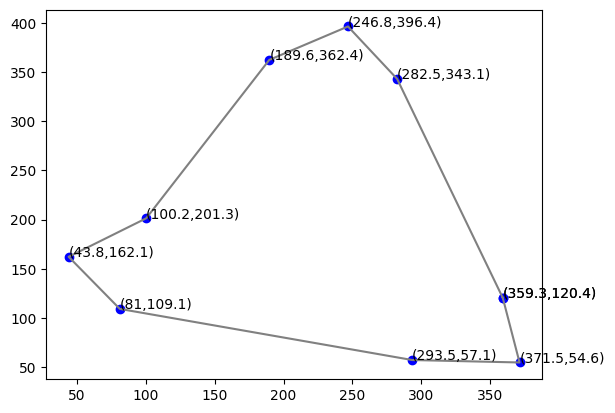

time elapsed in cheapest_link_algorithm: 4.099996294826269e-05 seconds
Shortest route: [(1, 6, 64.15122757983666), (2, 4, 64.75214282168584), (6, 7, 66.54201680141655), (3, 5, 66.92144648765448), (0, 4, 68.68478725307375), (3, 8, 78.04005381853602), (0, 7, 184.24323596810817), (2, 8, 218.7698562416678), (1, 5, 235.57064757732448)]
Minimum distance: 1047.6754145493037


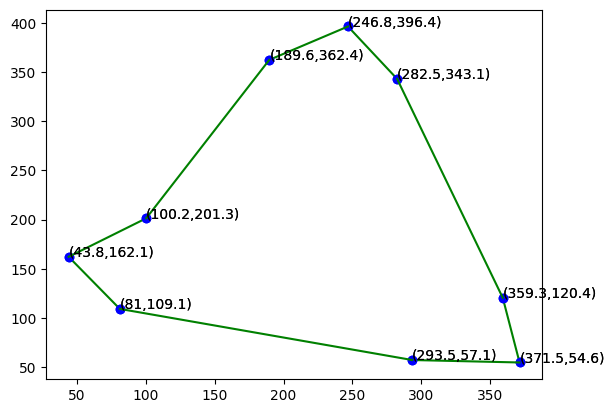

time elapsed in cheapest_insertion_algorithm: 7.058307528495789e-05 seconds
Shortest route: [(100.2, 201.3), (189.6, 362.4), (246.8, 396.4), (282.5, 343.1), (359.3, 120.4), (371.5, 54.6), (293.5, 57.1), (81, 109.1), (43.8, 162.1), (100.2, 201.3)]
Minimum distance: 1047.6754145493037


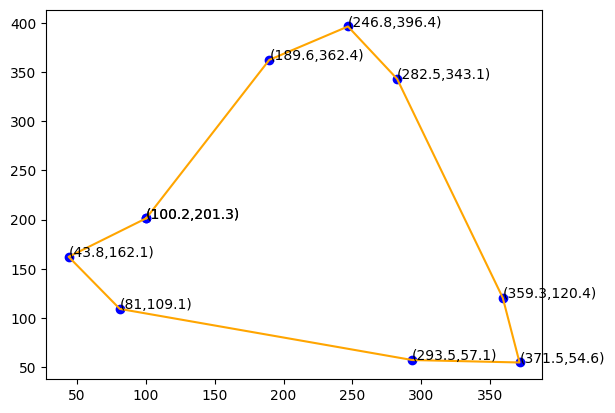

In [434]:
coordinates=convert2points('[{label:2,center:{x:100.2,y:201.3}},{label:3,center:{x:282.5,y:343.1}},{label:4,center:{x:81,y:109.1}},{label:"1",center:{x:371.5,y:54.6}},{label:"5",center:{x:43.8,y:162.1}},{label:6,center:{x:359.3,y:120.4}},{label:7,center:{x:246.8,y:396.4}},{label:8,center:{x:189.6,y:362.4}},{label:9,center:{x:293.5,y:57.1}}]')

shortest_route, min_distance =brute_force_tsp(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'blue')

shortest_route, min_distance =nearest_neighbor_algorithm_prof(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'red')

shortest_route, min_distance =nearest_neighbor_better_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'gray')

shortest_route, min_distance = cheapest_link_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
rr = [[coordinates[r[0]], coordinates[r[1]]] for r in shortest_route]
draw_ranges(rr, 'green')

shortest_route, min_distance = cheapest_insertion_algorithm(coordinates)
print("Shortest route:", shortest_route)
print("Minimum distance:", min_distance)
draw_path(shortest_route, 'orange')
